In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
import seaborn as sns
import sklearn
from sklearn import linear_model
from sklearn import preprocessing
%matplotlib inline
sns.set_style('white')

Use one of the following datasets to perform sentiment analysis on the given Amazon reviews. Pick one of the "small" datasets that is a reasonable size for your computer. The goal is to create a model to algorithmically predict if a review is positive or negative just based on its text. Try to see how these reviews compare across categories. Does a review classification model for one category work for another?

In [2]:
import gzip

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('reviews_Musical_Instruments_5.json.gz')

In [3]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014"


In [4]:
df.shape

(10261, 9)

In [5]:
list(df)

['reviewerID',
 'asin',
 'reviewerName',
 'helpful',
 'reviewText',
 'overall',
 'summary',
 'unixReviewTime',
 'reviewTime']

In [6]:
df['overall'].value_counts()

5.0    6938
4.0    2084
3.0     772
2.0     250
1.0     217
Name: overall, dtype: int64

1-4 is negative, 5 is positive; otherwise data will be skewed due to large number in 5

In [7]:
217 + 250 + 772 + 2084

3323

In [8]:
df['overall_2'] = np.where(df['overall'] >= 4.1, 1, 0)

In [9]:
list(df)

['reviewerID',
 'asin',
 'reviewerName',
 'helpful',
 'reviewText',
 'overall',
 'summary',
 'unixReviewTime',
 'reviewTime',
 'overall_2']

In [10]:
df['overall_2'].value_counts()

1    6938
0    3323
Name: overall_2, dtype: int64

In [3]:
6938/(6938+3323)

0.6761524217912485

# 1 = Positive, 0 = Negative

In [11]:
df.dtypes

reviewerID         object
asin               object
reviewerName       object
helpful            object
reviewText         object
overall           float64
summary            object
unixReviewTime      int64
reviewTime         object
overall_2           int64
dtype: object

In [12]:
from sklearn.feature_extraction import stop_words

In [14]:
stop = stop_words.ENGLISH_STOP_WORDS
df['reviewText_without_stopwords'] = df['reviewText'].apply(lambda x: ' '.join([word for word in x.split()if word not in (stop)]))

In [15]:
df['reviewText_without_stopwords'] = df['reviewText_without_stopwords'].str.replace(',', '')

In [16]:
print ('20 most common words in Review Text:')
pd.Series(' '.join(df['reviewText_without_stopwords']).lower().split()).value_counts()[:20]

20 most common words in Review Text:


i          25328
the         4602
guitar      4580
it          3775
like        3754
just        3665
it's        3368
great       3330
use         3316
good        3296
sound       3076
this        3031
strings     2666
really      2191
pedal       2127
little      2020
don't       1908
i've        1773
works       1723
used        1630
dtype: int64

In [25]:
keywords = ['love', 'loved', 'great', 'awesome', 'good', 'not', 'bad', 'price', 'value', 'happy', 'guitar', 
           'like', 'use', 'sound', 'strings', 'really', 'pedal', 'little', 'works', 'used']

for key in keywords:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    df[str(key)] = df['reviewText'].str.contains(
        ' ' + str(key) + ' ',
        case=False
    )

In [26]:
df.dtypes

reviewerID                       object
asin                             object
reviewerName                     object
helpful                          object
reviewText                       object
overall                         float64
summary                          object
unixReviewTime                    int64
reviewTime                       object
overall_2                         int64
title_without_stopwords          object
reviewText_without_stopwords     object
love                               bool
loved                              bool
great                              bool
awesome                            bool
good                               bool
not                                bool
bad                                bool
price                              bool
value                              bool
happy                              bool
guitar                             bool
like                               bool
use                                bool


                 overall  unixReviewTime  overall_2      love     loved  \
overall         1.000000       -0.008992   0.825776  0.076440 -0.010515   
unixReviewTime -0.008992        1.000000   0.000068 -0.008315 -0.000160   
overall_2       0.825776        0.000068   1.000000  0.088191  0.004836   
love            0.076440       -0.008315   0.088191  1.000000  0.028524   
loved          -0.010515       -0.000160   0.004836  0.028524  1.000000   
great           0.104413       -0.048973   0.095700  0.048729  0.032647   
awesome         0.036345       -0.003582   0.041413  0.045525  0.038993   
good           -0.039142       -0.067448  -0.077593  0.003896  0.009255   
not            -0.166717       -0.103500  -0.164591  0.036533  0.004340   
bad            -0.084645       -0.028471  -0.069761  0.016770  0.046613   
price          -0.011378       -0.054358  -0.027225  0.016966 -0.006000   
value           0.012425       -0.051420   0.002737  0.005714  0.008812   
happy           0.030740 

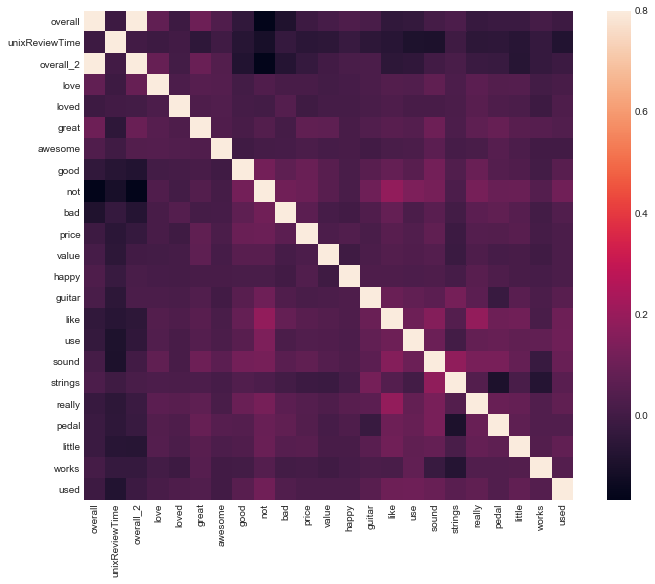

In [27]:
corrmat = df.corr()
print(corrmat)

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn.
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

In [28]:
data = df[keywords]
target = df['overall_2']

In [29]:
# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(data, target)

# Classify, storing the result in a new variable.
y_pred = bnb.predict(data)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))

Number of mislabeled points out of a total 10261 points : 3311


In [3]:
print ((1 - (3311/10261)), "percentage correct")

0.6773218984504434 percentage correct


In [4]:
# More advanced techniques will be learned later to further develop this